In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import torch
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from IPython.display import HTML
import matplotlib.animation as animation

import sac
import envs
import utils
import envs.maze_utils as maze_utils

from rnet.model import RNetModel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
logs_dir = '/checkpoint/linamezghani/offline-gcrl/logs/'

#exp_name = "20220420-030857_walker_oracleFalse-rs1.0-lr0.0005-bs2048-alpha0.008-gamma0.85-action_repeat2-1goal-grid_search"
exp_name = "20220506-123846_maze_U4rooms_rs0.01-lr0.0006-bs2048-updates1000-alpha0.05-gamma0.95-oracle-reward-rnet-asym"

%ls '{logs_dir}{exp_name}/agent'

checkpoint_0.pth     checkpoint_200.pth  checkpoint_500.pth  checkpoint_800.pth
checkpoint_100.pth   checkpoint_300.pth  checkpoint_600.pth  checkpoint_900.pth
checkpoint_1000.pth  checkpoint_400.pth  checkpoint_700.pth


In [2]:
ckpt = 1000
ckpt_path = f'{logs_dir}{exp_name}/agent/checkpoint_{ckpt}.pth'

In [6]:
tmp_path = f"{logs_dir}/multirun/{exp_name}"
cfg_path = f"{tmp_path}/{os.listdir(tmp_path)[0]}/.hydra/config.yaml"

cfg = OmegaConf.load(cfg_path)

cfg.env.random_start_pos = False
print(OmegaConf.to_yaml(cfg.env))

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)

id: maze_U4rooms
success_thresh: 0.5
max_episode_steps: 100
action_repeat: 1
random_start_pos: false
obs:
  type: vec
  state_size: 7
  vec_size: 7
  rgb_size: 64
action_dim: 2
obs_type: vec



In [7]:
vis_cfg = cfg.copy()
env = envs.make_env(cfg.env, space_info)

if cfg.env.obs.type == 'vec':
    vis_cfg.env.obs.type = 'rgb'
    space_info_rgb = utils.get_space_info(vis_cfg.env.obs, vis_cfg.env.action_dim)
vis_env = envs.make_env(vis_cfg.env, space_info_rgb)

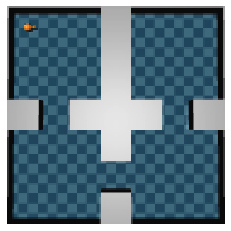

In [8]:
obs = vis_env.reset()
plt.imshow(obs['obs'].transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [12]:
cfg.sac.policy.frame_stack = 1
cfg.sac.policy.head.remove_velocity = False

In [13]:
device=torch.device("cuda:0")

space_info = utils.get_space_info(cfg.env.obs, cfg.env.action_dim)
agent = sac.SAC(cfg.sac, space_info, device)

agent.load_checkpoint(ckpt_path, evaluate=True)

Loading models from /checkpoint/linamezghani/offline-gcrl/logs/20220506-123846_maze_U4rooms_rs0.01-lr0.0006-bs2048-updates1000-alpha0.05-gamma0.95-oracle-reward-rnet-asym/agent/checkpoint_1000.pth


In [22]:
model = RNetModel(cfg.rnet.model, space_info)
model.to(device)
model.load(f'{logs_dir}{exp_name}/model.pth')
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '/checkpoint/linamezghani/offline-gcrl/logs/20220609-050853_maze_U4rooms_rs100.0-lr0.0001-alpha0.01-gamma0.95-act_model-reward-done-negact-fixQ-rb1M_s234_r0/model.pth'

In [15]:
def get_reward(model, state):
    obs = torch.from_numpy(state['obs']).float().to(device).unsqueeze(0)
    goal = torch.from_numpy(state['goal_obs']).float().to(device).unsqueeze(0)
    return model(obs, goal, batchwise=True)[:, 0].item()

def generate_episode_maze(env, goal_idx=None, vis=True, plot=False):
    video = []
    num_steps = cfg.env.max_episode_steps//cfg.env.action_repeat
    if plot:
        to_plot = {x: np.zeros(num_steps) for x in ['rnet_val', 'oracle_dist']}

    state = env.reset(goal_idx=goal_idx)
    new_state = {f"{k}obs": state[f"{k}state"] for k in ['', 'goal_']}
    if vis:
        video.append(
            np.concatenate((state['obs'], state['goal_obs']), axis=2).transpose(1, 2, 0)
        )
    for i in range(num_steps):
        with torch.no_grad():
            action = agent.select_action(new_state.copy(), evaluate=True)
        state, _, _, info = env.step(action)
        new_state = {f"{k}obs": state[f"{k}state"] for k in ['', 'goal_']}
        if vis:
            video.append(
                np.concatenate(
                    (state['obs'], state['goal_obs']), axis=2).transpose(1, 2, 0)
            )
        if plot:
            to_plot['rnet_val'][i] = get_reward(model, new_state)
            to_plot['oracle_dist'][i] = maze_utils.oracle_distance(
                state['state'], state['goal_state']
            )
    if plot:
        x = np.arange(num_steps) * cfg.env.action_repeat
        _, ax1 = plt.subplots()
        to_plot['rnet_val'] = torch.sigmoid(torch.from_numpy(to_plot['rnet_val']))

        color1 = 'tab:blue'
        ax1.plot(x, to_plot['rnet_val'], label='rnet_val', color=color1)
        ax1.set_ylabel('rnet_val', color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.plot(x, [0.5]*num_steps, color=color1, ls="--")

        color2 = 'tab:red'
        ax2 = ax1.twinx()
        ax2.plot(x, to_plot['oracle_dist'], label='oracle_dist', color=color2)
        ax2.set_ylabel('oracle_dist', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.plot(x, [cfg.env.success_thresh]*num_steps, color=color2, ls="--")

        ax1.grid()
        ax1.set_xlabel('step')
        plt.show()
    return info, np.array(video)

oracle_distance: 1.108
oracle_success: False


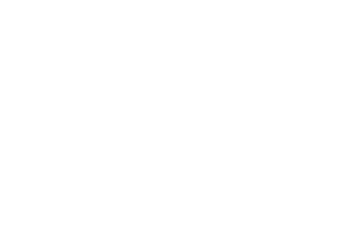

In [18]:
info, video = generate_episode_maze(vis_env, goal_idx=None, vis=True, plot=False)
print(f'oracle_distance: {round(info["oracle_distance"], 3)}')
print(f'oracle_success: {bool(info["oracle_success"])}')


imw = video.shape[2]
video[:, :, imw //2-1 : imw//2+1] = 0
fig = plt.figure()
plt.axis('off')
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=video.shape[0],interval=150, repeat=False
)
plt.axis('off')
HTML(anim.to_jshtml())

In [113]:
from rnet.memory import RNetMemory
import rnet.utils as rnet_utils
import envs.walker_utils as walker_utils

memory = RNetMemory(cfg.rnet.memory, space_info, cfg.rnet.model.feat_size, device)

exp_name = 'walker_thresh2'
save_dir = os.path.join('/checkpoint/linamezghani/offline-gcrl/rnet/', exp_name)
memory, NN = rnet_utils.load(save_dir, memory)

Loading rnet objects from  /checkpoint/linamezghani/offline-gcrl/rnet/walker_thresh2


In [123]:
goals = memory.get_goals()
print(goals)

{'state': array([[ 0.        ,  0.        , -1.30436728, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.0273921 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.74151532,  0.06582605,  2.64152777, ..., -7.10769666,
         1.82391028,  4.31500706],
       ...,
       [-0.30595146,  8.04389816, 12.23921904, ..., -0.91404087,
         8.5442962 , -5.49427009],
       [-1.22291485, -4.14561041, -8.02359307, ...,  2.98596679,
        -3.90158759, 29.64162658],
       [-0.68360663,  6.72339859,  0.42243664, ..., -1.96325124,
         7.28456845, -4.37858104]]), 'vec_obs': array([[ 0.26328817, -0.9647172 , -0.3070977 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.9934862 ,  0.11395248, -0.9990543 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.87755144,  0.47948247, -0.9899197 , ..., -7.1076965 ,
         1.8239102 ,  4.315007  ],
       ...,
       [ 0.9469615 , -0.321347  ,  0.99253595, ..., -

In [124]:
n = goals['vec_obs'].shape[0]
goals['rgb_obs'] = np.zeros((n, 3, 64, 64), dtype=np.uint8)
for i in range(n):
    state = goals['state'][i]
    obs = walker_utils.get_state_from_lexa(env, state[:9])
    goals['rgb_obs'][i] = env.get_image_from_obs(obs)

In [128]:
env.set_goals(goals)

In [126]:
goals['state'] = goals['state'][:, :9]

In [127]:
goals['state'].shape

(341, 9)